In [1]:
# Create a figure
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import my_funcs
import time
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata as g

wind  = xr.open_dataset('../../data/wind_gfs_latest.nc')
wind = my_funcs.adjust_lon_xr_dataset(wind, lon_name='lon')

wind = wind.sel(lon=slice(-50, 50), lat=slice(-30, -80))

seaice_lnlt = xr.open_dataset('../../data/LongitudeLatitudeGrid-s6250-Antarctic.hdf',
                              engine='netcdf4'
                             )

seaice    = xr.open_dataset('../../data/seaice_latest.hdf', engine='netcdf4')

seaice = seaice.rename({'ASI Ice Concentration': 'si_conc'})
seaice = seaice.assign_coords(lon=(["x", "y"], np.array(seaice_lnlt.Longitudes)))
seaice = seaice.assign_coords(lat=(["x", "y"], np.array(seaice_lnlt.Latitudes)))
seaice = seaice.assign(si=(["x", "y"], seaice.si_conc.values))
seaice = seaice.drop('si_conc')

# regrid the sea ice to linear grid
xnew=np.arange(-180, 180.1, 0.1)
ynew=np.arange(-85, -49.9, 0.1)

X = xnew # your longitudes you want to grid to
Y = ynew # your latitudies you want to grid to

x, y = np.meshgrid(xnew,ynew)

sic_new = np.ndarray([len(ynew), len(xnew)]) # setting a new sic array

x_, y_ = np.ravel(seaice.lon), np.ravel(seaice.lat)
x_[x_>180] = x_[x_>180]-360

si = np.ravel(seaice.si.values)
sic_new = g((y_, x_), si, (y, x), method='nearest')

sic_new[sic_new==0] = np.NaN
sic_new = np.ma.masked_invalid(sic_new)

sic = xr.Dataset(data_vars={'sic' : (('lat', 'lon'), sic_new)},
                 coords={'lat'  : ynew,
                         'lon'  : xnew})

sic = sic.sel(lon=slice(-50, 50), lat=slice(-85, -50))
# make custom colormap for the winds

# define the colors for the colormap used by the wind plot
colors = [
          (215, 219, 221),
          (93,  109, 126),
          (52,  73,  94),
          (244, 208, 63),
          (243, 156, 18),
          (255, 0,   0),
          (100, 30,  22)
         ]

# make the cmap of the wind
my_cmap = my_funcs.make_cmap(colors, bit=True)

# wind = wind.resample(time='1H').mean().bfill(dim='time').ffill(dim='time')
variable = wind['tau']

# set coords for the ship plans

site2_lats = [-64-(30/60),-64-(30/60),-64-(20/60),-64-(20/60),-64-(16/60),-64-(11/60),
              -64-(6/60), -64-(1/60), -63-(56/60),-63-(52/60),-63-(47/60),-63-(42/60),
              -63-(37/60),-63-(32/60),-63-(28/60),-63-(23/60),-63-(18/60),-63-(41/60)]

site2_lons = [3+(15/60),2+(27/60),2+(27/60),2+(27/60),2+(27/60),2+(27/60),2+(27/60),
              2+(27/60),2+(27/60),2+(27/60),2+(27/60),2+(27/60),2+(27/60),2+(27/60),
              2+(27/60),2+(27/60),2+(27/60),2+(27/60)]

site1_lats = [-55-(0/60),-55-(13/60),-55-(11/60),-55-(8/60),-55-(5/60),-55-(3/60),
              -55-(0/60),-54-(57/60),-54-(55/60),-54-(52/60),-54-(49/60),-54-(47/60),
              -55-(0/60)]
site1_lons = [0,0,0,0,0,0,0,0,0,0,0,0,0]

PB_lat = -70-(19/60)
PB_lon = 2+(57/60)


In [2]:
wind     = wind.bfill(dim='time').ffill(dim='time')
wind_1D  = wind.resample(time='1H').mean()
wind     = wind.interp_like(wind_1D)
variable = wind['tau']

/Users/marcel/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


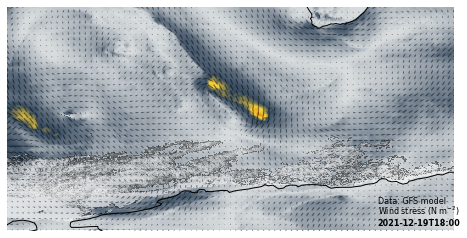

In [33]:
# wind animation

save_animation=True

# set up initial plot
fig = plt.figure(figsize=(8, 5), tight_layout=True)
ax  = fig.add_subplot(projection=ccrs.PlateCarree())

ax.coastlines(resolution='110m', zorder=5)
ax.set_extent([-50, 50, -75, -30])

image=ax.contourf(variable.lon, variable.lat, variable.sel(time=variable.time[0].values),
                  levels=np.arange(0, 1.3, 0.01),
                  cmap=my_cmap, extend='max',
                  transform=ccrs.PlateCarree())

skip=5

vctrs=ax.quiver(wind.lon[::skip], wind.lat[::skip],
                wind['u-component_of_wind_height_above_ground'].sel(time=variable.time[0].values)[::skip, ::skip],
                wind['v-component_of_wind_height_above_ground'].sel(time=variable.time[0].values)[::skip, ::skip],
                scale=1e3, zorder=3,
                headwidth=1, headlength=2,
                alpha=0.5,
                transform=ccrs.PlateCarree())

ax.pcolormesh(sic.lon, sic.lat,
              sic.sic, transform=ccrs.PlateCarree(),
              alpha=0.5,
              cmap='gray')

ax.text(33, -74, "Data: GFS model", fontsize=8)
ax.text(33, -76.5, 'Wind stress (N m$^{-2}$)', fontsize=8)
ax.text(33, -79, "%s"%str(wind.time[0].values)[:16], fontsize=8, fontweight='bold')

ax.spines['geo'].set_visible(False)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.margins(0,0)

MovieWriter ffmpeg unavailable; using Pillow instead.


2021-12-19T18:00:00.000000000
2021-12-19T18:00:00.000000000


/var/folders/n5/s6yw8y811f7bqlr9nb7w5rsr0000gn/T/ipykernel_12665/2454958336.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  anim.save('map_overview.gif', fps=15, dpi=300)


2021-12-19T19:00:00.000000000
2021-12-19T20:00:00.000000000
2021-12-19T21:00:00.000000000
2021-12-19T22:00:00.000000000
2021-12-19T23:00:00.000000000
2021-12-20T00:00:00.000000000
2021-12-20T01:00:00.000000000
2021-12-20T02:00:00.000000000
2021-12-20T03:00:00.000000000
2021-12-20T04:00:00.000000000
2021-12-20T05:00:00.000000000
2021-12-20T06:00:00.000000000
2021-12-20T07:00:00.000000000
2021-12-20T08:00:00.000000000
2021-12-20T09:00:00.000000000
2021-12-20T10:00:00.000000000
2021-12-20T11:00:00.000000000
2021-12-20T12:00:00.000000000
2021-12-20T13:00:00.000000000
2021-12-20T14:00:00.000000000
2021-12-20T15:00:00.000000000
2021-12-20T16:00:00.000000000
2021-12-20T17:00:00.000000000
2021-12-20T18:00:00.000000000
2021-12-20T19:00:00.000000000
2021-12-20T20:00:00.000000000
2021-12-20T21:00:00.000000000
2021-12-20T22:00:00.000000000
2021-12-20T23:00:00.000000000
2021-12-21T00:00:00.000000000
2021-12-21T01:00:00.000000000
2021-12-21T02:00:00.000000000
2021-12-21T03:00:00.000000000
2021-12-21

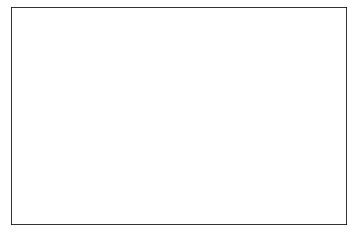

In [34]:
def update(t):
    # Update the plot for a specific time

    print(t)

    ax.clear()

    image=ax.contourf(variable.lon, variable.lat, variable.sel(time=t),
                      levels=np.arange(0, 1.3, 0.01),
                      cmap=my_cmap, extend='max',
                      transform=ccrs.PlateCarree())

    ax.pcolormesh(sic.lon, sic.lat,
                  sic.sic, transform=ccrs.PlateCarree(),
                  alpha=0.5,
                  cmap='gray')

    vctrs=ax.quiver(wind.lon[::skip], wind.lat[::skip],
                    wind['u-component_of_wind_height_above_ground'].sel(time=t)[::skip, ::skip],
                    wind['v-component_of_wind_height_above_ground'].sel(time=t)[::skip, ::skip],
                    scale=1e3, zorder=3,
                    headwidth=1, headlength=2,
                    alpha=0.5,
                    transform=ccrs.PlateCarree())
    
    ax.text(33, -74, "Data: GFS model", fontsize=8)
    ax.text(33, -76.5, 'Wind stress (N m$^{-2}$)', fontsize=8)
    time_stamp = ax.text(33, -79, "%s"%str(t)[:16], fontsize=8, fontweight='bold')

    ax.coastlines(resolution='110m', zorder=5)
    ax.set_extent([-50, 50, -75, -30])

    ax.spines['geo'].set_visible(False)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.margins(0,0)

    ax.scatter(site1_lons, site1_lats, s=2, c='m', edgecolor='k', transform=ccrs.PlateCarree())
    ax.scatter(site2_lons, site2_lats, s=2, c='m', edgecolor='k', transform=ccrs.PlateCarree())
    ax.scatter(PB_lon, PB_lat, s=5, c='m', edgecolor='k', transform=ccrs.PlateCarree())

    return image,vctrs,time_stamp



# Run the animation, applying `update()` for each of the times in the variable
anim = FuncAnimation(fig, update, frames=variable.time.values,
                     blit=False, repeat=True)

# Save to file or display on screen
if save_animation:
    anim.save('map_overview.gif', fps=15, dpi=300)